# Anomaly Dection on ECG Heartbeat Categorization Dataset

## Introduction
In this Jupyter notebook, we will embark on an exploration of the intriguing field of electrocardiogram (ECG) signal processing and classification, utilizing the capabilities of a Convolutional Neural Network (CNN) Autoencoder. Our chosen dataset for this journey is the PTB Diagnostic ECG Database, a meticulously curated collection of ECG signals crafted explicitly for diagnostic purposes. Our primary objective is to construct a robust Autoencoder model tailored for the task of detecting anomalous electrocardiogram (ECG) signals.

An electrocardiogram (ECG) is a medical test that detects cardiac (heart) abnormalities by measuring the electrical activity generated by the heart as it contracts.
ECGs are used to investigate and diagnose conditions affecting the heart. They can help to detect arrhythmias, heart attacks, and other heart conditions.


![ecg_example](img/SinusRhythmLabels.jpg)

There are three main components to an ECG:

- The P wave, which represents depolarization of the atria.
- The QRS complex, which represents depolarization of the ventricles.
- The T wave, which represents repolarization of the ventricles.


Source: [Wikipedia](https://en.wikipedia.org/wiki/Electrocardiography)


## Dataset Overview

The [PTB Diagnostic ECG](https://doi.org/10.13026/C28C71) Database is a collection of 14,552 ECG recordings sourced from Physionet's PTB Diagnostic Database. These ECG signals are categorized into two classes: normal heartbeats and those affected by cardiac abnormalities. The dataset is sampled at 125Hz, providing high-resolution data for in-depth analysis.

Let's delve into some essential details about the PTB Diagnostic ECG Database.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
normal_df = pd.read_pickle("./data/kaggleECG/ptbdb_normal.pkl")
anomaly_df = pd.read_pickle("./data/kaggleECG/ptbdb_abnormal.pkl")
print(f'Number of normal examples for {normal_df.shape[0]}')
print(f'Number of anomalous examples for {anomaly_df.shape[0]}')

Number of normal examples for 4046
Number of anomalous examples for 10506


Let's plot a couple of examples of normal and anoumalous ECGs.

In [10]:
len(normal_df.values[0])

188

In [11]:
def plot_examples(nlines = 3):
    fig, axs = plt.subplots(1,2,figsize = (8,3), dpi = 160)
    axs[0].plot(normal_df.values[:nlines].T)
    axs[1].plot(anomaly_df.values[0:nlines].T)
    axs[0].set_title('Normal ECGs')
    axs[1].set_title('Anoumalous ECGs')
    plt.show()

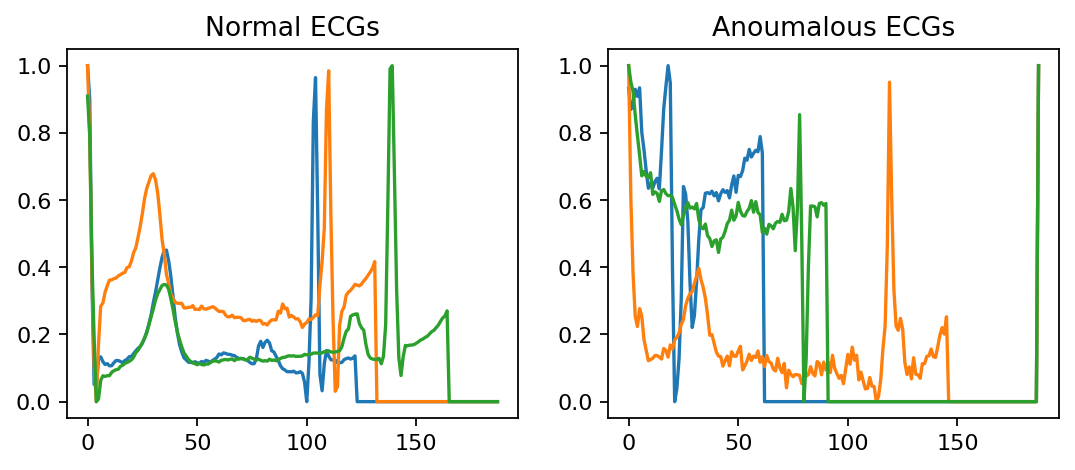

In [12]:
plot_examples()

Some clear similarity is visible in the normal ECGs, that are not present in the anomalous ECGs.

## AutoEncoders

Autoencoders are a class of neural network architectures commonly used in unsupervised machine learning and deep learning tasks. Their primary purpose is to discover and learn efficient representations of data by encoding it into a lower-dimensional latent space and subsequently decoding it back to its original form. Autoencoders play a crucial role in various applications, such as dimensionality reduction, data denoising, anomaly detection, and generative modeling.

The core components of an autoencoder consist of an encoder and a decoder. The encoder maps input data to the latent space, while the decoder reconstructs the data from its encoded representation. During training, autoencoders aim to minimize the reconstruction error between the input and the decoded output, which results in the learning of meaningful data representations.

![autoencoder](img/autoencoder.png)

 For the encored, we will use some 1D concolutional layers on the input data.

<img src="img/conv1d.png" alt="drawing" width="1000"/>

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class ConvEncoder(nn.Module):
    """ConvEncoder."""

    def __init__(
        self,
        input_size: int,
        output_size: int = 64
    ):
        """__init__.

        :param channels:
        :type channels: int
        :param hidden:
        :type hidden: int
        :param bottleneck:
        :type bottleneck: int
        """
        super().__init__()

        self.conv1d_1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=6, stride=3, padding=0)
        self.conv1d_2 = nn.Conv1d(in_channels=64,out_channels=32,kernel_size=6, stride=3)
        self.conv1d_3 = nn.Conv1d(in_channels=32,out_channels=1,kernel_size=15)
        self.lrelu = nn.LeakyReLU()
        self.fc1 = nn.Linear(5, output_size)

    def forward(self, x: torch.Tensor):
        """forward.

        :param x:
        :type x: torch.Tensor
        """
        x = x.unsqueeze(1)
        x = self.conv1d_1(x)
        x = self.lrelu(x)
        x = self.conv1d_2(x)
        x = self.lrelu(x)
        x = self.conv1d_3(x)
        x=x.squeeze(1)
        x = self.fc1(x)

        return x


For the decoder part, we will use transpose convolution.

<img src="img/transconv.png" alt="drawing" width="1000"/>

In [14]:

class ConvDecoder(nn.Module):
    """ConvDecoder."""

    def __init__(
        self,
        output_size: int,
        input_size: int = 64
    ):
        """__init__.

        :param channels:
        :param hidden:
        :param bottleneck:
        """
        super().__init__()

        self.fc2 = nn.Linear(input_size, 5)
        self.deconv1d_1 = nn.ConvTranspose1d(in_channels=1, out_channels=32,kernel_size=15)
        self.deconv1d_2 = nn.ConvTranspose1d(in_channels=32, out_channels=64,kernel_size=6, stride=3)
        self.deconv1d_3 = nn.ConvTranspose1d(in_channels=64, out_channels=1, kernel_size=6, stride=3, padding=0)
        self.linear = nn.Linear(183, output_size)  # Output dimension matches input_dim
        self.lrelu = nn.LeakyReLU()

    def forward(self, x: torch.Tensor):
        """forward.

        :param x:
        :type x: torch.Tensor
        """
        x = self.fc2(x)
        x = torch.unsqueeze(x,1)
        x = self.deconv1d_1(x)
        x = self.lrelu(x)
        x = self.deconv1d_2(x)
        x = self.lrelu(x)
        x = self.deconv1d_3(x)
        x = x.squeeze(1)
        x= self.linear(x)


        return x
    


The ConvAutoencoder will be:

In [15]:

class ConvAutoencoder(nn.Module):
    """ConvAutoencoder."""

    def __init__(self,
        input_size: int,
        latent_size: int = 64,
        device: str = 'cpu'
    ):
        """__init__.

        :param channels:
        :param hidden:
        :param bottleneck:
        :param device:
        """
        super().__init__()

        self.encoder = ConvEncoder(
            input_size = input_size,
            output_size = latent_size).to(device)
        self.decoder = ConvDecoder(
            input_size = latent_size,
            output_size = input_size).to(device)

    def forward(self, x: torch.Tensor):
        """forward.

        :param x:
        :type x: torch.Tensor
        """
        x = self.encoder(x)
        x = self.decoder(x)
        return x



## Data preprocessing

Let's take the normal dataset and split it in train/test datasets.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(normal_df.values, test_size=0.15, random_state=45, shuffle=True)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}, anomaly shape: {anomaly_df.shape}")

Train shape: (3439, 188), Test shape: (607, 188), anomaly shape: (10506, 188)


## Model training

In [17]:
BATCHSIZE = 32
# Instantiate the PyTorch model
input_dim = X_train.shape[-1]
latent_dim = 64
model = ConvAutoencoder(input_dim, latent_dim)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

# Convert your dataset to PyTorch DataLoader
# Assuming your dataset is in the form of a PyTorch Tensor
train_loader = DataLoader(TensorDataset(torch.tensor(X_train)), batch_size=BATCHSIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test)), batch_size=BATCHSIZE, shuffle=True)

# Lists to store training and testing losses
train_losses = []
test_losses = []

# Training the Autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs = data[0].float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Testing
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs = data[0].float()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            test_loss += loss.item()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    avg_test_loss = test_loss / len(test_loader)

    # Store losses in arrays
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    # Print training and testing statistics
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

Epoch [1/10], Train Loss: 0.0770, Test Loss: 0.0532
Epoch [2/10], Train Loss: 0.0526, Test Loss: 0.0510
Epoch [3/10], Train Loss: 0.0514, Test Loss: 0.0504
Epoch [4/10], Train Loss: 0.0511, Test Loss: 0.0508
Epoch [5/10], Train Loss: 0.0504, Test Loss: 0.0494
Epoch [6/10], Train Loss: 0.0478, Test Loss: 0.0459
Epoch [7/10], Train Loss: 0.0453, Test Loss: 0.0441
Epoch [8/10], Train Loss: 0.0435, Test Loss: 0.0419
Epoch [9/10], Train Loss: 0.0416, Test Loss: 0.0403
Epoch [10/10], Train Loss: 0.0400, Test Loss: 0.0395


Let's visualize the train and test loss.

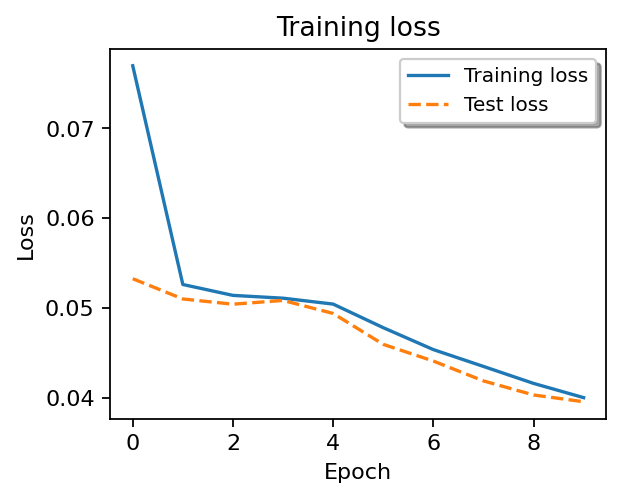

In [18]:
fig = plt.figure(figsize = (4,3), dpi = 160)
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Test loss", ls="--")
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.title("Training loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

## Model evaluation

Let's now evaluate the model performance.

In [19]:
def evaluate_model(model, data):
    model.eval()
    inputs = torch.tensor(data).float()
    with torch.no_grad():
        outputs = model(inputs)
    return outputs.detach().numpy()

In [20]:
outputs_tr = evaluate_model(model,X_train)
outputs_ts = evaluate_model(model,X_test)
outputs_anomaly = evaluate_model(model,anomaly_df.values)

Let's visualize if the autoencoder is not correctly reconstructing anomalies as expected.

In [21]:
import numpy as np

def plot_prediction(data, predictions, title, ax):
  loss = np.mean(abs(data - predictions))

  ax.plot(data, label='True')
  ax.plot(predictions, label='Reconstructed')
  ax.set_title(f'{title} (MAE: {np.around(loss, 2)})')
  ax.legend()
  
def plot_predictions(ncols = 4):
  fig, axs = plt.subplots(
    nrows=2,
    ncols=ncols,
    sharey=True,
    sharex=True,
    figsize=(3*ncols, 6)
  )

  for i, (data, prediction) in enumerate(zip(X_test[:ncols], outputs_ts[:ncols])):
    plot_prediction(data, prediction, title='Normal', ax=axs[0, i])

  for i,(data, prediction) in enumerate(zip(anomaly_df.values[:ncols], outputs_anomaly[:ncols])):
    plot_prediction(data, prediction, title='Anomaly', ax=axs[1, i])

  fig.tight_layout()

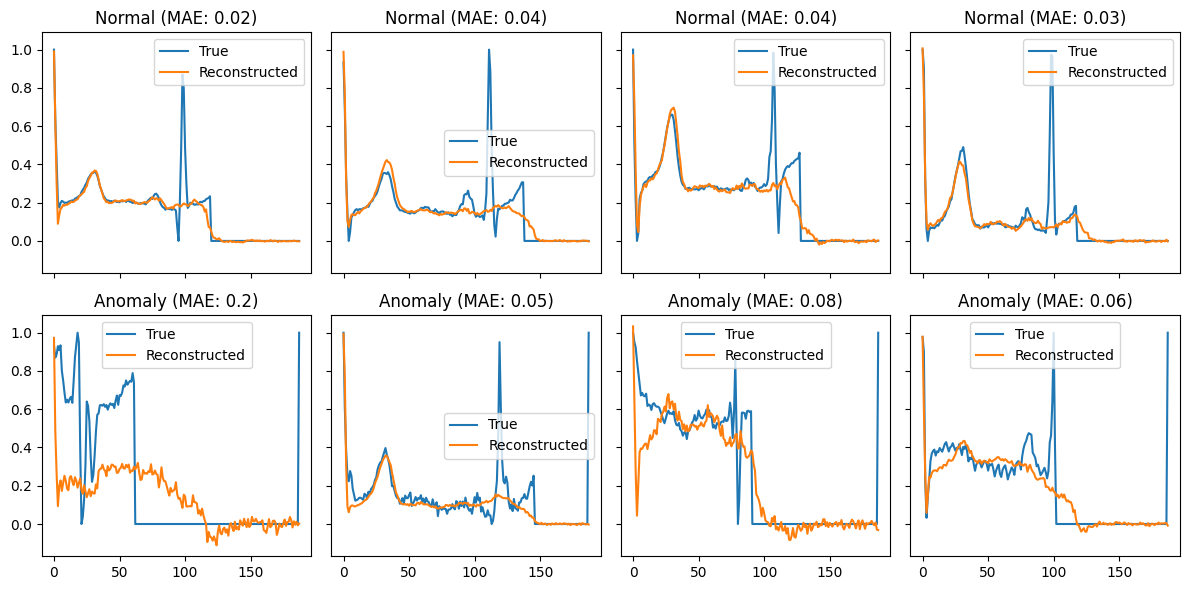

In [22]:
plot_predictions()

Now let's define our reconstruction error.

In [23]:
error_tr = np.mean(abs(outputs_tr - X_train), axis = 1)
error_ts = np.mean(abs(outputs_ts - X_test), axis = 1)
error_anomaly = np.mean(abs(outputs_anomaly - anomaly_df.values), axis = 1)

In [24]:
import matplotlib.pyplot as plt

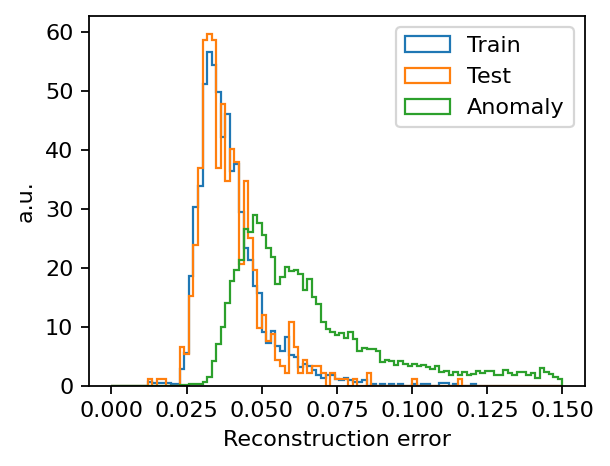

In [25]:
bins = np.linspace(0,0.15,100)
fig = plt.figure(figsize=(4,3), dpi = 160)
plt.hist(error_tr, bins = bins, label = 'Train', density = True, histtype='step')
plt.hist(error_ts, bins = bins, label = 'Test', density = True, histtype='step')
plt.hist(error_anomaly, bins = bins, label = 'Anomaly', density = True, histtype='step')
plt.legend()
plt.xlabel('Reconstruction error')
plt.ylabel('a.u.')

plt.show()

In [26]:
print(f'Maximum reco error for anomaly is {np.max(error_anomaly):.2f}')
print(f'Maximum reco error for normal is {np.max(error_ts):.2f}')

Maximum reco error for anomaly is 0.29
Maximum reco error for normal is 0.12


Given the Reconstruction error we can now fix threshold to distinguish between normal and anomalous data.

In [27]:
THR = 0.05

## Excercises

### Excercise 1: produce the ROC curve plot


In [28]:
def true_positive(anomaly_score, thr):
    return(len(anomaly_score[anomaly_score > thr])/len(anomaly_score))
    

In [29]:
TPR = true_positive(error_anomaly, THR)
print(f'True Positive Rate is {TPR:.2f}')

True Positive Rate is 0.71


In [30]:
# Define here the FP function
def false_positive(normal_score,thr):
    return(len(normal_score[normal_score> thr])/len(normal_score))

In [31]:
FPR = false_positive(error_ts, THR)
print(f'False Positive Rate is {FPR:.2f}')

False Positive Rate is 0.13


In [32]:
thresholds = np.linspace(0., 0.3, 100)

In [33]:
print(f'Threshold array is {thresholds[:4]}')

Threshold array is [0.         0.0030303  0.00606061 0.00909091]


In [34]:
TPR_list = []
FPR_list = []
for thr in thresholds:
    TPR = true_positive(error_anomaly, thr)
    FPR = false_positive(error_ts, thr)
    TPR_list.append(TPR)
    FPR_list.append(FPR)    

In [35]:
# Define here the plot function
def plot_ROC(FPR_vals, TPR_vals):
    fig = plt.figure(figsize=(4,3), dpi = 160)
    plt.plot(FPR_vals, TPR_vals, 'o--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    fig.show()

/tmp/ipykernel_43896/3226753515.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


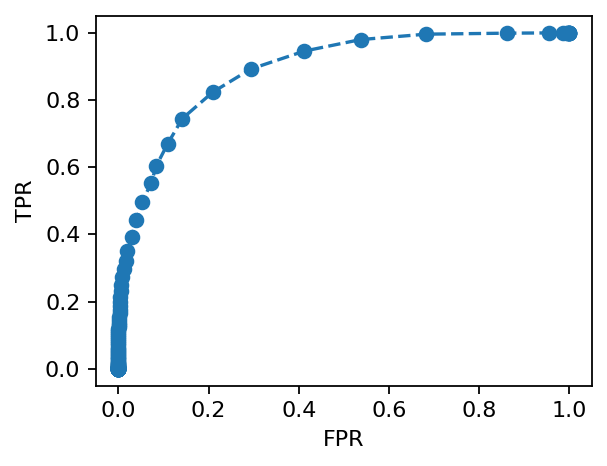

In [36]:
plot_ROC(FPR_list, TPR_list)

### Excercise 2: train a linear autoencoder

In [37]:
# Define here the LinearAutoencoder, replacing the Conv1d Laters with lieanr layers (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) .

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class Encoder(nn.Module):
    """Encoder."""

    def __init__(
        self,
        input_size: int,
        output_size: int = 64
    ):
        """__init__.

        :param channels:
        :type channels: int
        :param hidden:
        :type hidden: int
        :param bottleneck:
        :type bottleneck: int
        """
        super().__init__()

        self.linear_1 = nn.Linear(in_features=input_size, out_features=256)
        self.linear_2 = nn.Linear(in_features=256, out_features=128)
        self.linear_3 = nn.Linear(in_features=128, out_features=output_size)
        self.lrelu = nn.LeakyReLU()

    def forward(self, x: torch.Tensor):
        """forward.

        :param x:
        :type x: torch.Tensor
        """
        # x = x.unsqueeze(1)
        x = self.linear_1(x)
        x = self.lrelu(x)
        x = self.linear_2(x)
        x = self.lrelu(x)
        x = self.linear_3(x)
        return x


In [48]:

class Decoder(nn.Module):
    """ConvDecoder."""

    def __init__(
        self,
        output_size: int,
        input_size: int = 64
    ):
        """__init__.

        :param channels:
        :param hidden:
        :param bottleneck:
        """
        super().__init__()

        self.linear_1 = nn.Linear(in_features=input_size, out_features=100)
        self.linear_2 = nn.Linear(in_features=100, out_features=160)
        self.linear_3 = nn.Linear(in_features=160, out_features=output_size)
        self.lrelu = nn.LeakyReLU()

    def forward(self, x: torch.Tensor):
        """forward.

        :param x:
        :type x: torch.Tensor
        """
        x = self.linear_1(x)
        x = self.lrelu(x)
        x = self.linear_2(x)
        x = self.lrelu(x)
        x = self.linear_3(x)
        return x
    


In [49]:

class Autoencoder(nn.Module):
    """ConvAutoencoder."""

    def __init__(self,
        input_size: int,
        latent_size: int = 64,
        device: str = 'cpu'
    ):
        """__init__.

        :param channels:
        :param hidden:
        :param bottleneck:
        :param device:
        """
        super().__init__()

        self.encoder = Encoder(
            input_size = input_size,
            output_size = latent_size).to(device)
        self.decoder = Decoder(
            input_size = latent_size,
            output_size = input_size).to(device)

    def forward(self, x: torch.Tensor):
        """forward.

        :param x:
        :type x: torch.Tensor
        """
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [50]:
BATCHSIZE = 32
# Instantiate the PyTorch model
input_dim = X_train.shape[-1]
latent_dim = 64
model = Autoencoder(input_dim, latent_dim)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

# Convert your dataset to PyTorch DataLoader
# Assuming your dataset is in the form of a PyTorch Tensor
train_loader = DataLoader(TensorDataset(torch.tensor(X_train)), batch_size=BATCHSIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test)), batch_size=BATCHSIZE, shuffle=True)

# Lists to store training and testing losses
train_losses = []
test_losses = []

# Training the Autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs = data[0].float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Testing
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs = data[0].float()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            test_loss += loss.item()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    avg_test_loss = test_loss / len(test_loader)

    # Store losses in arrays
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    # Print training and testing statistics
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

Epoch [1/10], Train Loss: 0.0670, Test Loss: 0.0469
Epoch [2/10], Train Loss: 0.0446, Test Loss: 0.0420
Epoch [3/10], Train Loss: 0.0402, Test Loss: 0.0387
Epoch [4/10], Train Loss: 0.0372, Test Loss: 0.0360
Epoch [5/10], Train Loss: 0.0341, Test Loss: 0.0328
Epoch [6/10], Train Loss: 0.0327, Test Loss: 0.0316
Epoch [7/10], Train Loss: 0.0313, Test Loss: 0.0311
Epoch [8/10], Train Loss: 0.0305, Test Loss: 0.0307
Epoch [9/10], Train Loss: 0.0297, Test Loss: 0.0294
Epoch [10/10], Train Loss: 0.0289, Test Loss: 0.0285


In [51]:
outputs_tr_linear = evaluate_model(model,X_train)
outputs_ts_linear = evaluate_model(model,X_test)
outputs_anomaly_linear = evaluate_model(model,anomaly_df.values)

In [52]:
error_tr_linear = np.mean(abs(outputs_tr_linear - X_train), axis = 1)
error_ts_linear = np.mean(abs(outputs_ts_linear - X_test), axis = 1)
error_anomaly_linear = np.mean(abs(outputs_anomaly_linear - anomaly_df.values), axis = 1)

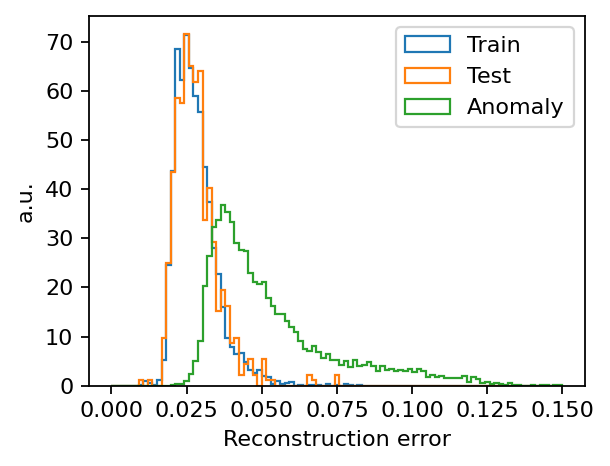

In [53]:
bins = np.linspace(0,0.15,100)
fig = plt.figure(figsize=(4,3), dpi = 160)
plt.hist(error_tr_linear, bins = bins, label = 'Train', density = True, histtype='step')
plt.hist(error_ts_linear, bins = bins, label = 'Test', density = True, histtype='step')
plt.hist(error_anomaly_linear, bins = bins, label = 'Anomaly', density = True, histtype='step')
plt.legend()
plt.xlabel('Reconstruction error')
plt.ylabel('a.u.')

plt.show()

In [54]:
TPR_linear_list = []
FPR_linear_list = []
for thr in thresholds:
    TPR = true_positive(error_anomaly_linear, thr)
    FPR = false_positive(error_ts_linear, thr)
    TPR_linear_list.append(TPR)
    FPR_linear_list.append(FPR)  

/tmp/ipykernel_43896/302613313.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


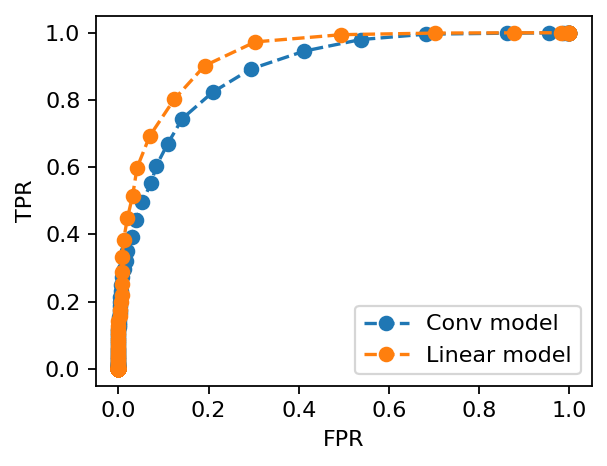

In [57]:
fig = plt.figure(figsize=(4,3), dpi = 160)
plt.plot(FPR_list, TPR_list, 'o--', label = 'Conv model')
plt.plot(FPR_linear_list, TPR_linear_list, 'o--',label = 'Linear model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
fig.show()